In [1]:
!ls

get-pip.py   main_load_track_file.py  test_imports.py  可视化.ipynb
__init__.py  main_visualize_data.py   utils


In [2]:
run test_imports.py

Trying to import csv (for loading track files).
ok

Trying to import lanelet2 (for loading maps).
ok

Trying to import xml (for loading maps without lanelet2).
ok

Trying to import pyproj (for loading maps without lanelet2).
Could not import pyproj.
  Not too bad, since you have lanelet2 to load the map.

Trying to import argparse (argument parsing for loading and visualizing tracks).
ok

Trying to import os (check file existence for loading and visualizing tracks).
ok

Trying to import time (for scenario playback).
ok

Trying to import math (for visualizing tracks).
ok

Trying to import matplotlib (for visualizing tracks).
ok

Trying to import numpy (for visualizing tracks).
ok


In [3]:
#run main_load_track_file.py ../recorded_trackfiles/DR_CHN_Merging_ZS/vehicle_tracks_000.csv #显示不出来？？

usage: main_load_track_file.py [-h] [filename]
main_load_track_file.py: error: unrecognized arguments: #显示不出来？？


SystemExit: 2

In [ ]:
# python-tk 报错的话开个控制台 sudo apt-get install python-tk

<IPython.core.display.Javascript object>


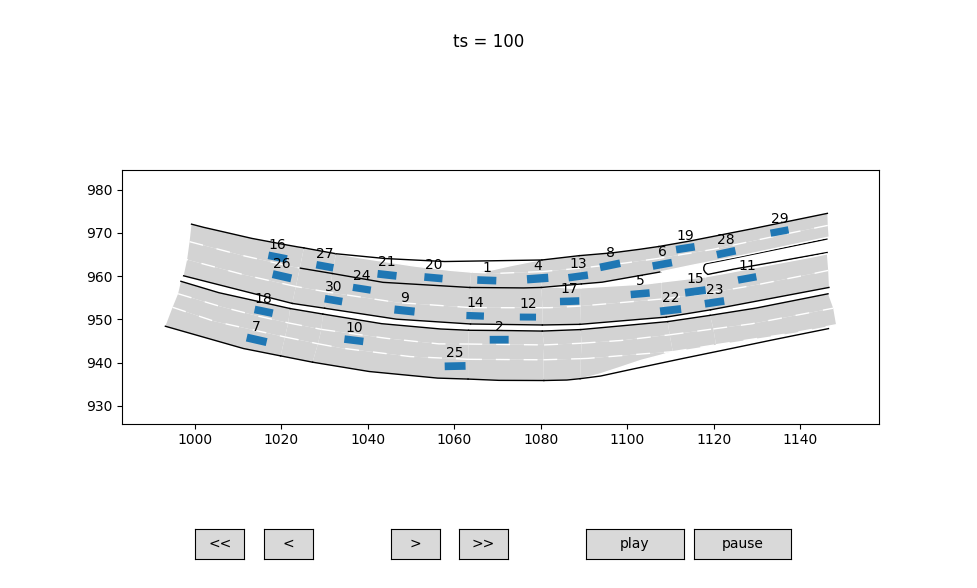

Loading map...
Loading tracks...
Plotting...


In [5]:
#!/usr/bin/env python
    
import lanelet2
use_lanelet2_lib = True

import argparse
import os
import time
import matplotlib.pyplot as plt
#%matplotlib inline
%matplotlib nbagg
from matplotlib.widgets import Button

from utils import dataset_reader
from utils import dataset_types
from utils import map_vis_lanelet2
from utils import tracks_vis
from utils import dict_utils


def update_plot():
    global fig, timestamp, title_text, track_dictionary, patches_dict, text_dict, axes
    # update text and tracks based on current timestamp
    assert(timestamp <= timestamp_max), "timestamp=%i" % timestamp
    assert(timestamp >= timestamp_min), "timestamp=%i" % timestamp
    assert(timestamp % dataset_types.DELTA_TIMESTAMP_MS == 0), "timestamp=%i" % timestamp
    title_text.set_text("\nts = {}".format(timestamp))
    tracks_vis.update_objects_plot(timestamp, track_dictionary, patches_dict, text_dict, axes)
    fig.canvas.draw()


def start_playback():
    global timestamp, timestamp_min, timestamp_max, playback_stopped
    playback_stopped = False
    plt.ion()
    while timestamp < timestamp_max and not playback_stopped:
        timestamp += dataset_types.DELTA_TIMESTAMP_MS
        start_time = time.time()
        update_plot()
        end_time = time.time()
        diff_time = end_time - start_time
        plt.pause(max(0.001, dataset_types.DELTA_TIMESTAMP_MS / 1000. - diff_time))
    plt.ioff()


class FrameControlButton(object):
    def __init__(self, position, label):
        self.ax = plt.axes(position)
        self.label = label
        self.button = Button(self.ax, label)
        self.button.on_clicked(self.on_click)

    def on_click(self, event):
        global timestamp, timestamp_min, timestamp_max, playback_stopped

        if self.label == "play":
            if not playback_stopped:
                return
            else:
                start_playback()
                return
        playback_stopped = True
        if self.label == "<<":
            timestamp -= 10*dataset_types.DELTA_TIMESTAMP_MS
        elif self.label == "<":
            timestamp -= dataset_types.DELTA_TIMESTAMP_MS
        elif self.label == ">":
            timestamp += dataset_types.DELTA_TIMESTAMP_MS
        elif self.label == ">>":
            timestamp += 10*dataset_types.DELTA_TIMESTAMP_MS
        timestamp = min(timestamp, timestamp_max)
        timestamp = max(timestamp, timestamp_min)
        update_plot()


if __name__ == "__main__":
        
    scenario_name = "DR_CHN_Merging_ZS" #Name of the scenario (to identify map and folder for track
    track_file_number = 0 #Number of the track file (int), default=0
    start_timestamp = 100 # try with 0 first, if throw AssertError, start_timestamp = timestamp_min

    # check folders and files
    error_string = ""
    tracks_dir = "../recorded_trackfiles"
    maps_dir = "../maps"
    lanelet_map_ending = ".osm"
    lanelet_map_file = maps_dir + "/" + scenario_name + lanelet_map_ending
    scenario_dir = tracks_dir + "/" + scenario_name
    track_file_prefix = "vehicle_tracks_"
    track_file_ending = ".csv"
    track_file_name = scenario_dir + "/" + track_file_prefix + str(track_file_number).zfill(3) + track_file_ending
    if not os.path.isdir(tracks_dir):
        error_string += "Did not find track file directory \"" + tracks_dir + "\"\n"
    if not os.path.isdir(maps_dir):
        error_string += "Did not find map file directory \"" + tracks_dir + "\"\n"
    if not os.path.isdir(scenario_dir):
        error_string += "Did not find scenario directory \"" + scenario_dir + "\"\n"
    if not os.path.isfile(lanelet_map_file):
        error_string += "Did not find lanelet map file \"" + lanelet_map_file + "\"\n"
    if not os.path.isfile(track_file_name):
        error_string += "Did not find track file \"" + track_file_name + "\"\n"
    if error_string != "":
        error_string += "Type --help for help."
        raise IOError(error_string)

    # create a figure
    fig, axes = plt.subplots(1, 1)
    fig.canvas.set_window_title("Interaction Dataset Visualization")

    # load and draw the lanelet2 map, either with or without the lanelet2 library
    lat_origin = 0.  # origin is necessary to correctly project the lat lon values in the osm file to the local
    lon_origin = 0.  # coordinates in which the tracks are provided; we decided to use (0|0) for every scenario
    print("Loading map...")
    if use_lanelet2_lib:
        projector = lanelet2.projection.UtmProjector(lanelet2.io.Origin(lat_origin, lon_origin))
        laneletmap = lanelet2.io.load(lanelet_map_file, projector)
        map_vis_lanelet2.draw_lanelet_map(laneletmap, axes)
    else:
        map_vis_without_lanelet.draw_map_without_lanelet(lanelet_map_file, axes, lat_origin, lon_origin)

    # load the tracks
    print("Loading tracks...")
    track_dictionary = dataset_reader.read_tracks(track_file_name)

    timestamp_min = 1e9
    timestamp_max = 0
    for key, track in dict_utils.get_item_iterator(track_dictionary):
        timestamp_min = min(timestamp_min, track.time_stamp_ms_first)
        timestamp_max = max(timestamp_max, track.time_stamp_ms_last)

    if start_timestamp is None:
        start_timestamp = timestamp_min

    button_pp = FrameControlButton([0.2, 0.05, 0.05, 0.05], '<<')
    button_p = FrameControlButton([0.27, 0.05, 0.05, 0.05], '<')
    button_f = FrameControlButton([0.4, 0.05, 0.05, 0.05], '>')
    button_ff = FrameControlButton([0.47, 0.05, 0.05, 0.05], '>>')

    button_play = FrameControlButton([0.6, 0.05, 0.1, 0.05], 'play')
    button_pause = FrameControlButton([0.71, 0.05, 0.1, 0.05], 'pause')

    # storage for track visualization
    patches_dict = dict()
    text_dict = dict()

    # visualize tracks
    print("Plotting...")
    timestamp = start_timestamp
    title_text = fig.suptitle("")
    playback_stopped = True
    update_plot()
    plt.show()


In [ ]:
timestamp_min